# **PROYECTO DE GRADO - MAESTRIA EN CIENCIA DE DATOS**
## Segmentación de profesionales de la salud del sector farmacéutico
### Santiago Reyes Zabaleta


## Clusterización Jerárquica
-------------------------------------------------------------------------------------

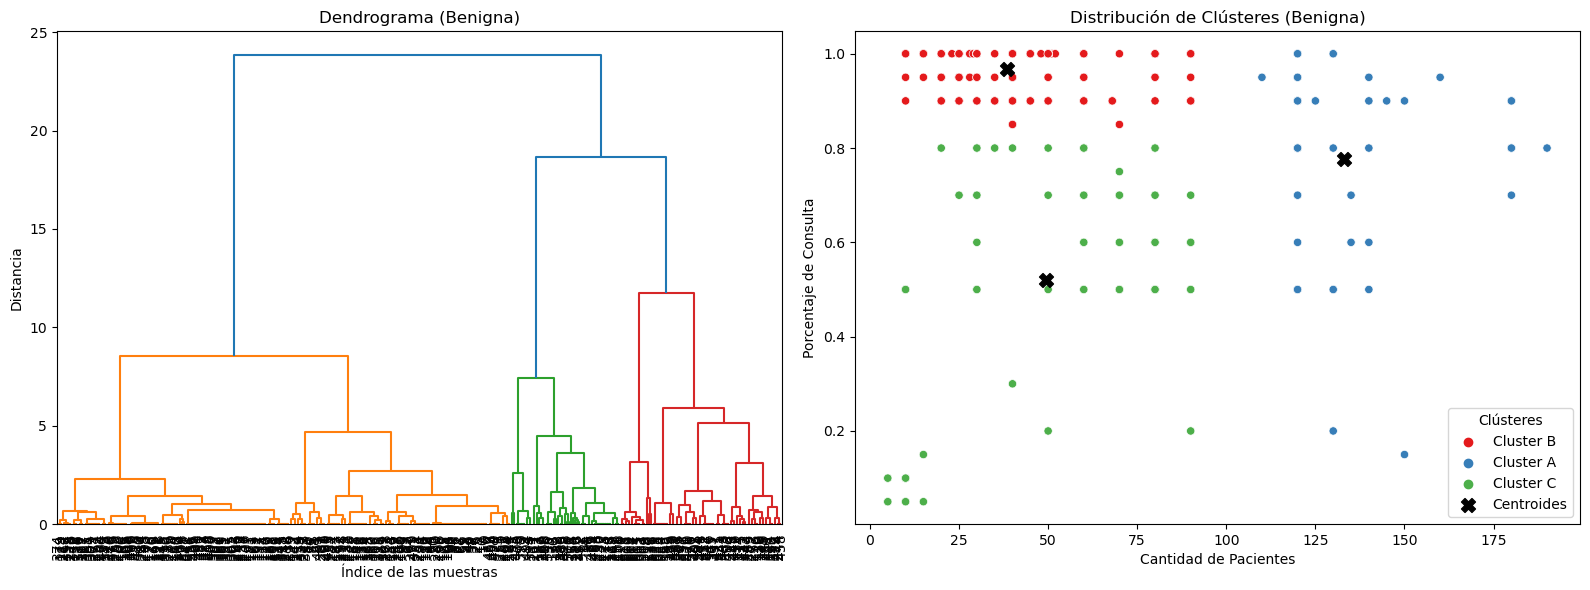

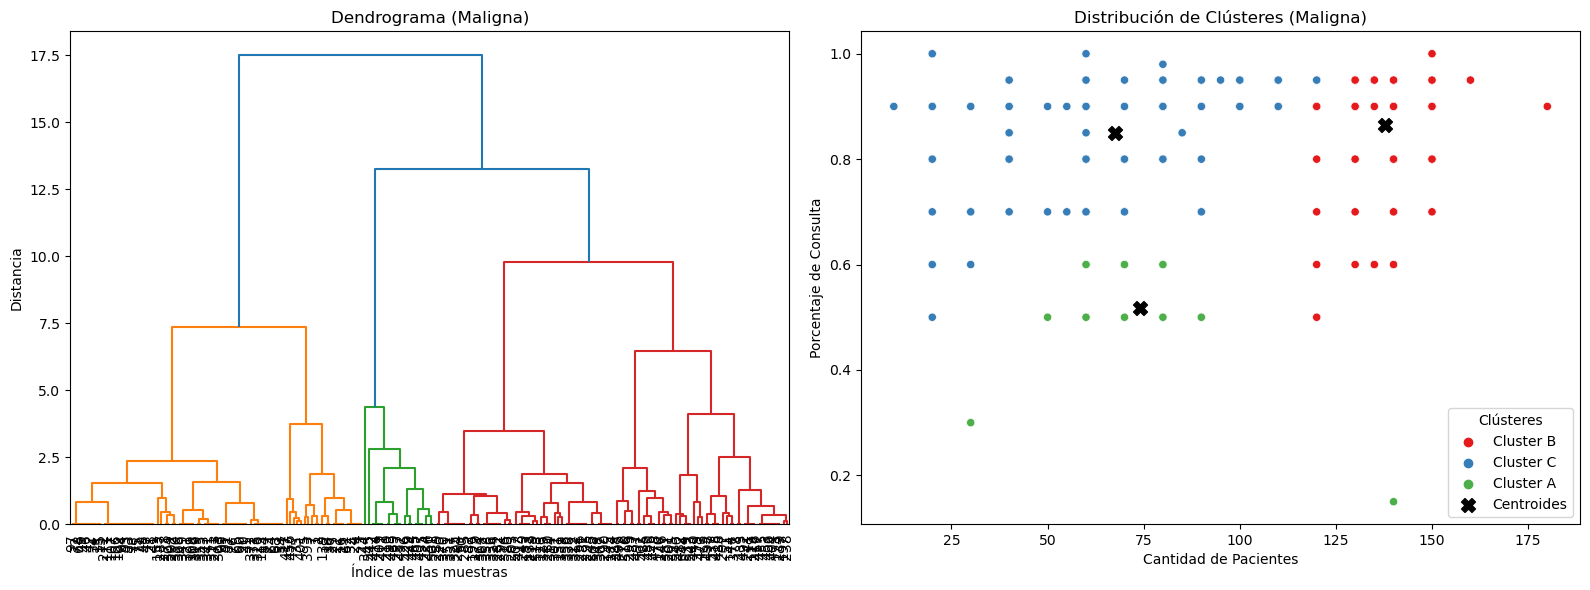

In [34]:
# Importar las bibliotecas necesarias
import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Función para realizar la clusterización jerárquica con nombres de clústeres actualizados en las gráficas
def clusterizacion_con_graficos_y_nombres(data, tipo_consulta, variables, num_clusters, cluster_names):
    # Filtrar los datos según el tipo de consulta
    datos = data[data['tipo_consulta'] == tipo_consulta]

    if datos.empty:
        print(f"No hay datos para consultas {tipo_consulta}.")
        return None

    # Filtrar las columnas relevantes para la clusterización
    cluster_data = datos[variables]

    # Normalizar los datos
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(cluster_data)

    # Crear la matriz de enlaces
    linkage_matrix = linkage(scaled_data, method='ward')

    # Crear un gráfico agrupado para el dendrograma y la distribución de clústeres
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Dendrograma
    dendrogram(linkage_matrix, labels=datos.index, leaf_rotation=90, leaf_font_size=10, ax=axes[0])
    axes[0].set_title(f"Dendrograma ({tipo_consulta.capitalize()})")
    axes[0].set_xlabel("Índice de las muestras")
    axes[0].set_ylabel("Distancia")

    # Asignar un número fijo de clústeres
    clusters = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

    # Renombrar los clústeres según los nombres personalizados
    cluster_map = {i: name for i, name in enumerate(cluster_names, 1)}
    datos['Cluster'] = [cluster_map[cluster] for cluster in clusters]

    # Calcular los centroides
    centroides = datos.groupby('Cluster')[variables].mean()

    # Gráfico de dispersión con nombres personalizados en la leyenda
    sns.scatterplot(x=datos['Cantidad_pacientes'], y=datos['porcentaje_consulta'],
                    hue=datos['Cluster'], palette='Set1', ax=axes[1])
    axes[1].scatter(centroides['Cantidad_pacientes'], centroides['porcentaje_consulta'], 
                    color='black', s=100, marker='X', label='Centroides')
    axes[1].set_title(f"Distribución de Clústeres ({tipo_consulta.capitalize()})")
    axes[1].set_xlabel("Cantidad de Pacientes")
    axes[1].set_ylabel("Porcentaje de Consulta")
    axes[1].legend(title="Clústeres")

    # Ajustar diseño
    plt.tight_layout()
    plt.show()

    # Retornar el DataFrame completo con los clústeres asignados
    return datos

# Cargar los datos
data = pd.read_csv('data_cleaned.csv')

# Variables relevantes para el análisis
variables = ["Cantidad_pacientes", "porcentaje_consulta"]

# Nombres personalizados para benignos y malignos
nombres_clusters_benignos = ["Cluster B", "Cluster A", "Cluster C"]
nombres_clusters_malignos_corregidos = ["Cluster B", "Cluster A", "Cluster C"]

# Ejecutar el análisis para benignas
resultados_benignas_nombres = clusterizacion_con_graficos_y_nombres(
    data, "benigna", variables, num_clusters=3, cluster_names=nombres_clusters_benignos)

# Guardar los resultados para benignas
#if resultados_benignas_nombres is not None:
#    resultados_benignas_nombres.to_csv('benignas_clustered_nombres_actualizados.csv', index=False)
#    print("Datos con clústeres actualizados para benignas guardados en 'benignas_clustered_nombres_actualizados.csv'.")

# Ejecutar el análisis para malignas con los nombres corregidos
resultados_malignos_nombres_corregidos = clusterizacion_con_graficos_y_nombres(
    data, "maligna", variables, num_clusters=3, cluster_names=nombres_clusters_malignos_corregidos)

# Guardar los resultados corregidos para malignas
#if resultados_malignos_nombres_corregidos is not None:
#    resultados_malignos_nombres_corregidos.to_csv('malignos_clustered_nombres_corregidos.csv', index=False)
#    print("Datos con clústeres corregidos para malignas guardados en 'malignos_clustered_nombres_corregidos.csv'.")

In [19]:
# Combinar los resultados de benignas y malignas en un solo DataFrame
def combinar_resultados_clusterizacion(benignas_df, malignas_df):
    # Añadir una columna para indicar el tipo de consulta
    benignas_df['tipo_consulta'] = 'benigna'
    malignas_df['tipo_consulta'] = 'maligna'
    
    # Combinar los DataFrames
    combinado = pd.concat([benignas_df, malignas_df], ignore_index=True)
    return combinado

# Combinar los DataFrames generados
resultados_combinados = combinar_resultados_clusterizacion(resultados_benignas_nombres, resultados_malignos_nombres_corregidos)

# Guardar el DataFrame combinado en un archivo CSV
resultados_combinados.to_csv('resultados_clusterizados_Jerarquizacion_combinados.csv', index=False)
print("Datos combinados de clusterización guardados en 'resultados_clusterizados_Jerarquizacion_combinados.csv'.")

Datos combinados de clusterización guardados en 'resultados_clusterizados_Jerarquizacion_combinados.csv'.


In [21]:
# Realizar análisis estadístico por clúster
estadisticas_por_cluster = resultados_combinados.groupby(['Cluster']).agg({
    'Cantidad_pacientes': ['mean', 'std', 'min', 'max'],
    'porcentaje_consulta': ['mean', 'std', 'min', 'max']
}).reset_index()

# Calcular la cantidad de registros por clúster
cantidad_por_cluster = resultados_combinados['Cluster'].value_counts().reset_index()
cantidad_por_cluster.columns = ['Cluster', 'Cantidad']


In [22]:
cantidad_por_cluster

,Cluster,Cantidad
0,Cluster B,298
1,Cluster C,176
2,Cluster A,72


In [23]:
estadisticas_por_cluster

Cluster Cantidad_pacientes                     porcentaje_consulta  \
                           mean        std min  max                mean   
0  Cluster A         116.666667  33.671989  30  190            0.704167   
1  Cluster B          65.704698  47.978391  10  180            0.939933   
2  Cluster C          59.659091  30.074151   5  120            0.705000   

                        
        std   min  max  
0  0.216527  0.15  1.0  
1  0.078706  0.50  1.0  
2  0.236027  0.05  1.0

In [25]:
# Análisis cruzado de conteo con clústeres como columnas

# Calcular el conteo por especialidad y clúster
conteo_pivot = resultados_combinados.pivot_table(
    index='especialidad',
    columns='Cluster',
    values='Cantidad_pacientes',
    aggfunc='count',
    fill_value=0
).reset_index()

# Calcular la fila de totales por especialidad
conteo_pivot['Total'] = conteo_pivot.iloc[:, 1:].sum(axis=1)

# Calcular la columna de totales por clúster
total_por_cluster = conteo_pivot.sum(axis=0)
total_por_cluster['especialidad'] = 'Total'

# Agregar la fila de totales al DataFrame
conteo_pivot = pd.concat([conteo_pivot, pd.DataFrame(total_por_cluster).T], ignore_index=True)

# Ordenar por la columna de totales de mayor a menor
conteo_pivot = conteo_pivot.sort_values(by='Total', ascending=False, ignore_index=True)

conteo_pivot

Cluster,especialidad,Cluster A,Cluster B,Cluster C,Total
0,Total,72,298,176,546
1,HEMATOLOGO,26,43,70,139
2,PEDIATRA,2,75,14,91
3,HEMATOLOGO PEDIATRA,22,38,30,90
4,GENETISTA,9,49,8,66
5,HEMATONCOLOGO,4,27,24,55
6,MEDICO GENERAL,6,8,15,29
7,MEDICO INTERNISTA,2,14,7,23
8,ORTOPEDISTA,0,19,3,22
9,NEURO PEDIATRA,1,9,0,10


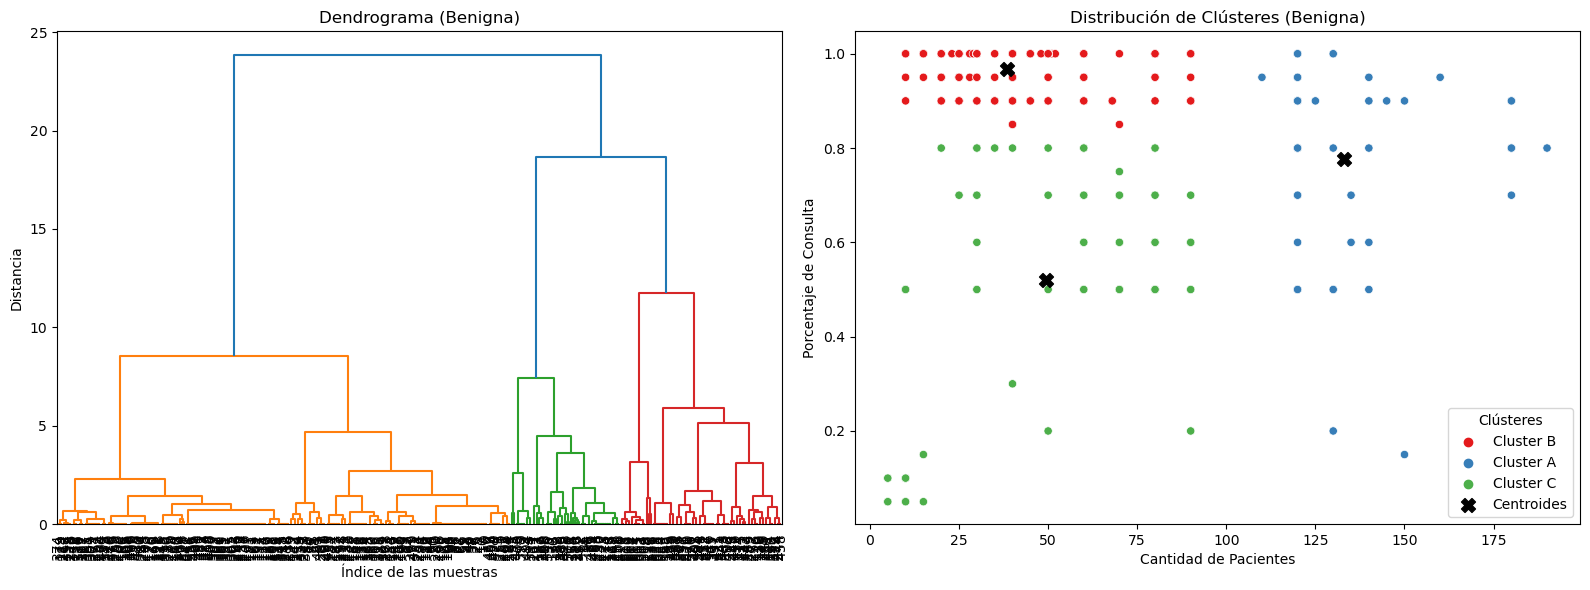

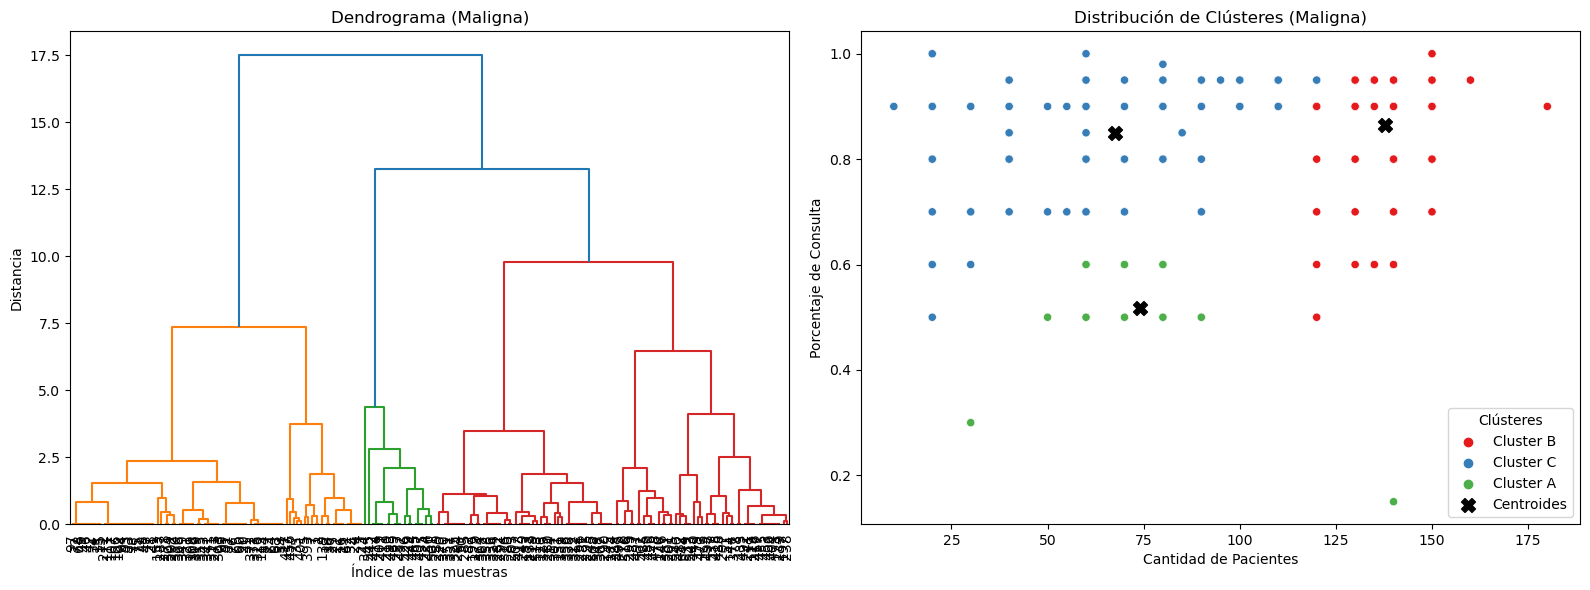

     Cluster Cantidad_pacientes                     porcentaje_consulta  \
                           mean        std min  max                mean   
0  Cluster A         116.666667  33.671989  30  190            0.704167   
1  Cluster B          65.704698  47.978391  10  180            0.939933   
2  Cluster C          59.659091  30.074151   5  120            0.705000   

                        
        std   min  max  
0  0.216527  0.15  1.0  
1  0.078706  0.50  1.0  
2  0.236027  0.05  1.0  
     Cluster  Cantidad
0  Cluster B       298
1  Cluster C       176
2  Cluster A        72


Cluster,especialidad,Cluster A,Cluster B,Cluster C,Total
0,Total,72,298,176,546
1,HEMATOLOGO,26,43,70,139
2,PEDIATRA,2,75,14,91
3,HEMATOLOGO PEDIATRA,22,38,30,90
4,GENETISTA,9,49,8,66
5,HEMATONCOLOGO,4,27,24,55
6,MEDICO GENERAL,6,8,15,29
7,MEDICO INTERNISTA,2,14,7,23
8,ORTOPEDISTA,0,19,3,22
9,NEURO PEDIATRA,1,9,0,10


In [32]:
# Importar las bibliotecas necesarias
import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
import seaborn as sns

# Función para realizar la clusterización jerárquica con nombres personalizados
def clusterizacion_con_graficos_y_nombres(data, tipo_consulta, variables, num_clusters, cluster_names):
    datos = data[data['tipo_consulta'] == tipo_consulta]
    if datos.empty:
        print(f"No hay datos para consultas {tipo_consulta}.")
        return None
    cluster_data = datos[variables]
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(cluster_data)
    linkage_matrix = linkage(scaled_data, method='ward')
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    dendrogram(linkage_matrix, labels=datos.index, leaf_rotation=90, leaf_font_size=10, ax=axes[0])
    axes[0].set_title(f"Dendrograma ({tipo_consulta.capitalize()})")
    axes[0].set_xlabel("Índice de las muestras")
    axes[0].set_ylabel("Distancia")
    clusters = fcluster(linkage_matrix, num_clusters, criterion='maxclust')
    cluster_map = {i: name for i, name in enumerate(cluster_names, 1)}
    datos['Cluster'] = [cluster_map[cluster] for cluster in clusters]
    centroides = datos.groupby('Cluster')[variables].mean()
    sns.scatterplot(x=datos['Cantidad_pacientes'], y=datos['porcentaje_consulta'],
                    hue=datos['Cluster'], palette='Set1', ax=axes[1])
    axes[1].scatter(centroides['Cantidad_pacientes'], centroides['porcentaje_consulta'], 
                    color='black', s=100, marker='X', label='Centroides')
    axes[1].set_title(f"Distribución de Clústeres ({tipo_consulta.capitalize()})")
    axes[1].set_xlabel("Cantidad de Pacientes")
    axes[1].set_ylabel("Porcentaje de Consulta")
    axes[1].legend(title="Clústeres")
    plt.tight_layout()
    plt.show()
    return datos

# Función para combinar resultados de benignas y malignas
def combinar_resultados_clusterizacion(benignas_df, malignas_df):
    benignas_df['tipo_consulta'] = 'benigna'
    malignas_df['tipo_consulta'] = 'maligna'
    combinado = pd.concat([benignas_df, malignas_df], ignore_index=True)
    return combinado

# Función para análisis estadístico
def analisis_estadistico(resultados_combinados):
    estadisticas_por_cluster = resultados_combinados.groupby(['Cluster']).agg({
        'Cantidad_pacientes': ['mean', 'std', 'min', 'max'],
        'porcentaje_consulta': ['mean', 'std', 'min', 'max']
    }).reset_index()
    cantidad_por_cluster = resultados_combinados['Cluster'].value_counts().reset_index()
    cantidad_por_cluster.columns = ['Cluster', 'Cantidad']
    return estadisticas_por_cluster, cantidad_por_cluster

# Función para análisis cruzado con conteos
def generar_analisis_cruzado(resultados_combinados):
    conteo_pivot = resultados_combinados.pivot_table(
        index='especialidad',
        columns='Cluster',
        values='Cantidad_pacientes',
        aggfunc='count',
        fill_value=0
    ).reset_index()
    conteo_pivot['Total'] = conteo_pivot.iloc[:, 1:].sum(axis=1)
    total_por_cluster = conteo_pivot.sum(axis=0)
    total_por_cluster['especialidad'] = 'Total'
    conteo_pivot = pd.concat([conteo_pivot, pd.DataFrame(total_por_cluster).T], ignore_index=True)
    conteo_pivot = conteo_pivot.sort_values(by='Total', ascending=False, ignore_index=True)
    return conteo_pivot

# Cargar datos
data = pd.read_csv('data_cleaned.csv')
variables = ["Cantidad_pacientes", "porcentaje_consulta"]
nombres_clusters_benignos = ["Cluster B", "Cluster A", "Cluster C"]
nombres_clusters_malignos_corregidos = ["Cluster B", "Cluster A", "Cluster C"]

# Clusterización jerárquica
resultados_benignas_nombres = clusterizacion_con_graficos_y_nombres(
    data, "benigna", variables, num_clusters=3, cluster_names=nombres_clusters_benignos)
resultados_malignos_nombres_corregidos = clusterizacion_con_graficos_y_nombres(
    data, "maligna", variables, num_clusters=3, cluster_names=nombres_clusters_malignos_corregidos)

# Combinar resultados
resultados_combinados = combinar_resultados_clusterizacion(resultados_benignas_nombres, resultados_malignos_nombres_corregidos)

# Análisis estadístico
estadisticas_por_cluster, cantidad_por_cluster = analisis_estadistico(resultados_combinados)

# Generar análisis cruzado
conteo_cruzado_final = generar_analisis_cruzado(resultados_combinados)

# Guardar resultados
#resultados_combinados.to_csv('resultados_combinados.csv', index=False)
#conteo_cruzado_final.to_csv('conteo_cruzado_final.csv', index=False)
#estadisticas_por_cluster.to_csv('estadisticas_por_cluster.csv', index=False)
#cantidad_por_cluster.to_csv('cantidad_por_cluster.csv', index=False)

print(estadisticas_por_cluster)
print(cantidad_por_cluster)
conteo_cruzado_final


In [33]:
from sklearn.metrics import silhouette_score, silhouette_samples

# Convertir los clústeres a valores numéricos para el cálculo del índice de silueta
resultados_combinados['Cluster_Num'] = resultados_combinados['Cluster'].astype('category').cat.codes

# Seleccionar las columnas relevantes para el cálculo del índice de silueta
data_scaled = resultados_combinados[["Cantidad_pacientes", "porcentaje_consulta"]]

# Calcular el índice de silueta promedio
silhouette_avg = silhouette_score(data_scaled, resultados_combinados['Cluster_Num'])

# Calcular las puntuaciones de silueta individuales para cada punto
silhouette_values = silhouette_samples(data_scaled, resultados_combinados['Cluster_Num'])

# Mostrar el índice de silueta promedio
print(f"Índice de Silueta Promedio: {silhouette_avg:.4f}")

Índice de Silueta Promedio: -0.0678


# Reporte de Análisis de Clusterización Jerárquica y Evaluación del Modelo

## 1. Objetivo del Análisis
El objetivo de este análisis fue realizar una **clusterización jerárquica** de los datos relacionados con consultas médicas benignas y malignas, segmentando los datos en clústeres con el fin de identificar patrones subyacentes y facilitar la toma de decisiones en la gestión de consultas médicas. Además, se evaluó la calidad de la segmentación utilizando el **índice de silueta** y se generaron varios análisis estadísticos para evaluar la distribución y características de los clústeres.

---

## 2. Clusterización Jerárquica

### Método Utilizado
La **clusterización jerárquica** fue aplicada a las variables **Cantidad de pacientes** y **Porcentaje de consulta**, dos características clave que se utilizó para segmentar los datos. Para determinar el número óptimo de clústeres, se basó en la observación visual del dendrograma y se seleccionaron 3 clústeres.

### Resultados Generales
Se obtuvieron 3 clústeres, y a cada uno se le asignó un nombre personalizado:
- **Cluster A**
- **Cluster B**
- **Cluster C**

La segmentación mostró grupos homogéneos con diferencias notables en las características de las consultas. Sin embargo, se observó que algunos clústeres podrían estar sobrelapeando, lo que sugiere que la segmentación podría no ser óptima.

---

## 3. Análisis Estadístico

### Estadísticas Descriptivas por Clúster
Se calcularon estadísticas descriptivas clave para cada clúster, incluyendo el **promedio**, **desviación estándar**, **mínimo** y **máximo** para las variables **Cantidad de pacientes** y **Porcentaje de consulta**. Los resultados indicaron que los clústeres presentan:
- Diferencias significativas en el número de pacientes asignados a cada clúster.
- Variabilidad en los porcentajes de consulta entre los clústeres.

Estos resultados proporcionan una comprensión más profunda de cómo las consultas se agrupan en función de sus características y pueden ser útiles para dirigir estrategias más personalizadas.

### Cantidad de Registros por Clúster
Se calculó la cantidad de registros por cada clúster. Esta métrica reveló que algunos clústeres tienen una mayor concentración de registros, lo que puede ayudar a priorizar las áreas que requieren mayor atención.

---

## 4. Análisis Cruzado por Especialidad y Clúster

### Método de Análisis Cruzado
Se generó un análisis cruzado que mostró la distribución de los clústeres a través de las **especialidades médicas**. Esto permitió observar cómo se distribuyen las consultas dentro de cada especialidad y cuántos registros corresponden a cada combinación de especialidad y clúster.

### Resultados
- Las especialidades muestran patrones específicos dentro de cada clúster.
- Algunos clústeres parecen estar dominados por ciertas especialidades, lo que puede ayudar a identificar áreas con alta concentración de ciertos tipos de consultas.

---

## 5. Evaluación del Modelo

### Índice de Silueta
El **índice de silueta** fue calculado para evaluar la cohesión y separación de los clústeres. El valor obtenido fue **-0.0678**, lo que sugiere que los clústeres no están bien definidos. Un índice negativo indica que algunas observaciones podrían estar mal asignadas a su clúster o que algunos clústeres se superponen.

### Conclusiones del Índice de Silueta
- El valor negativo indica que la segmentación podría no ser adecuada.
- Es recomendable ajustar el número de clústeres o explorar otros métodos de clustering para mejorar la calidad de la segmentación.
- Modelos alternativos como **K-means** o **DBSCAN** pueden ser considerados para validar estos resultados.

---

## 6. Recomendaciones

### Mejoras Potenciales en el Modelo
1. **Ajuste del Número de Clústeres**: Considerar el uso de diferentes cantidades de clústeres para ver si el modelo mejora, especialmente explorando más o menos de tres clústeres.
2. **Evaluación Visual Adicional**: Utilizar herramientas visuales adicionales, como gráficos 3D o proyecciones, para una mejor interpretación de los resultados.
3. **Modelos Alternativos de Clusterización**: Probar con otros modelos de clusterización como **K-means**, **DBSCAN** o **gmm** (Gaussian Mixture Models), los cuales podrían resultar más efectivos en ciertos tipos de datos.

### Aplicación Práctica de los Resultados
- **Segmentación de Consultas**: Los clústeres y el análisis cruzado pueden utilizarse para mejorar la segmentación de las consultas, ayudando a priorizar y personalizar el tratamiento de diferentes tipos de consultas en función de su especialidad y características.
- **Estrategias de Atención**: Basado en los clústeres, se pueden desarrollar estrategias específicas de atención médica, considerando tanto la cantidad de pacientes como los porcentajes de consulta.
- **Toma de Decisiones**: La información obtenida puede ayudar a los responsables de la toma de decisiones a entender mejor la distribución de las consultas y gestionar los recursos de manera más eficiente.

---

## 7. Conclusión General
El análisis de clusterización jerárquica ha permitido segmentar las consultas médicas de forma efectiva, aunque la evaluación del modelo, basada en el índice de silueta, sugiere que la segmentación podría mejorarse. A pesar de esto, los resultados del análisis cruzado y las estadísticas descriptivas proporcionan información valiosa para mejorar la segmentación y personalizar las estrategias de atención médica.

